# Assignment (part 1, Unsupervised)

In [4]:
import numpy as np # for linear algebra
import pandas as pd # for data processing, csv io
from matplotlib import pyplot as plt # data plots
import seaborn as sns # pretty data plots
sns.set()
import re
from sklearn.preprocessing import LabelEncoder # for label normalization
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import seaborn as sb # visualization
from mpl_toolkits.mplot3d import Axes3D # 3d plot
from termcolor import colored as cl # text customization

from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.cluster import KMeans # K-means algorithm

plt.rcParams['figure.figsize'] = (20, 10)
sb.set_style('whitegrid')

### Exploration of the dataset. Descriptive statistics. 

In [5]:
df_trans = pd.read_csv('Downloads/Datasets/transactions.csv')
df_types = pd.read_csv('Downloads/Datasets/types.csv', sep='delimiter')
df_codes = pd.read_csv('Downloads/Datasets/codes.csv', sep='delimiter')
df_train = pd.read_csv('Downloads/Datasets/train_set.csv')
df_test = pd.read_csv('Downloads/Datasets/test_set.csv')

<ipython-input-5-2fe3ba8f4767>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_types = pd.read_csv('Downloads/Datasets/types.csv', sep='delimiter')
<ipython-input-5-2fe3ba8f4767>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_codes = pd.read_csv('Downloads/Datasets/codes.csv', sep='delimiter')


In [6]:
df_trans[['client_id', 'datetime', 'code', 'type', 'sum']] = df_trans['client_id;datetime;code;type;sum'].str.split(';', expand=True)
del df_trans['client_id;datetime;code;type;sum']

df_types[['type', 'type_description']] = df_types['type;type_description'].str.split(';', expand=True)
del df_types['type;type_description']

df_codes[['code', 'code_description']] = df_codes['code;code_description'].str.split(';', expand=True)
del df_codes['code;code_description']

df_train[['client_id', 'target']] = df_train['client_id;target'].str.split(';', expand=True)
del df_train['client_id;target']

In [7]:
join_codes = df_trans.merge(df_codes, on='code', how='left')

In [8]:
join_types = join_codes.merge(df_types, on='type', how='left')

In [9]:
df_joined = join_types.merge(df_train, on='client_id', how='left')

In [10]:
df_joined

,client_id,datetime,code,type,sum,code_description,type_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0
1,24567813,377 17:20:40,6011,7010,67377.47,Финансовые институты — снятие наличности автом...,Взнос наличных через АТМ (в своем тер.банке),NaN
2,21717441,55 13:38:47,6011,2010,-44918.32,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0
3,14331004,263 12:57:08,6011,2010,-3368873.66,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,NaN
4,85302434,151 10:34:12,4814,1030,-3368.87,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы,0
...,...,...,...,...,...,...,...,...
130034,15836839,147 11:50:53,5411,1010,-26344.59,"Бакалейные магазины, супермаркеты",Покупка. POS,NaN
130035,28369355,305 11:59:34,4829,2330,-24705.07,Денежные переводы,Списание с карты по операции “перевода с карты...,0
130036,40949707,398 21:13:58,5411,1110,-40353.72,"Бакалейные магазины, супермаркеты",Покупка. POS,1
130037,7174462,409 13:58:14,5411,1010,-25536.06,"Бакалейные магазины, супермаркеты",Покупка. POS,1


### Data Preparation
In the data preprocessing part, we will mainly look for

missings and fill them 

changing the necessary data types

In [11]:
print('Number of missing data:')
print(df_joined.isnull().sum())
df_joined.describe(include='all')

Number of missing data:
client_id               0
datetime                0
code                    0
type                    0
sum                     0
code_description        0
type_description       41
target              38213
dtype: int64


,client_id,datetime,code,type,sum,code_description,type_description,target
count,130039,130039,130039,130039,130039,130039,129998,91826
unique,8656,114770,175,67,27450,175,57,2
top,70780820,456 00:00:00,6011,1010,-2245.92,Финансовые институты — снятие наличности автом...,Покупка. POS,0
freq,2777,60,27917,30802,7487,27917,48450,46715


[Text(0.5, 1.0, 'Missing Data'),
 Text(0.5, 66.453125, 'Columns'),
 Text(156.5, 0.5, 'Data Points')]

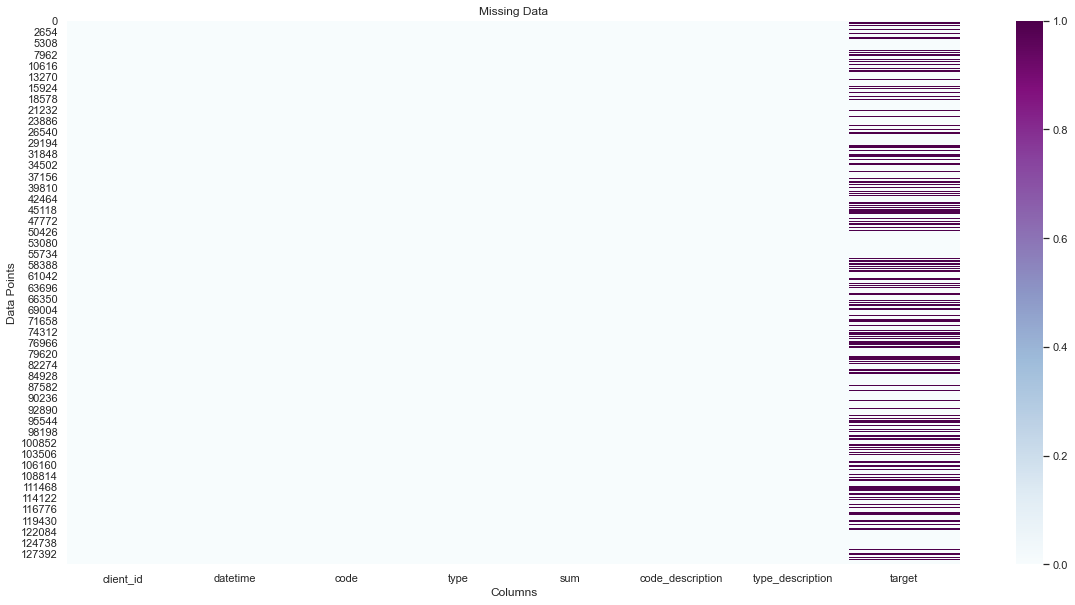

In [12]:
sns.heatmap(df_joined.isnull(), cmap="BuPu").set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

In [13]:
df=df_joined
df['target'] = pd.to_numeric(df['target'],errors = 'coerce')
df['sum'] = pd.to_numeric(df['sum'],errors = 'coerce')

In [14]:
df.groupby('target')[['sum']].median()

,sum
target,
0.0,-4731.70
1.0,-5682.17


In [15]:
df_joined.describe()

,sum,target
count,1.300390e+05,91826.000000
mean,-1.812909e+04,0.491266
std,5.584445e+05,0.499926
min,-4.150030e+07,0.000000
25%,-2.244916e+04,0.000000
50%,-5.502490e+03,0.000000
75%,-1.122960e+03,1.000000
max,6.737747e+07,1.000000


In [16]:
df_joined['type_description'].fillna(0, inplace=True)

In [17]:
# deleting all null values
df_joined = df_joined.dropna()
df_joined

,client_id,datetime,code,type,sum,code_description,type_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0
2,21717441,55 13:38:47,6011,2010,-44918.32,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0
4,85302434,151 10:34:12,4814,1030,-3368.87,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы,0.0
5,31421357,398 00:00:00,5411,1110,-1572.14,"Бакалейные магазины, супермаркеты",Покупка. POS,0.0
6,84826852,423 15:27:55,6010,7070,5654.99,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через Мобильный бан...,1.0
...,...,...,...,...,...,...,...,...
130033,57224158,380 13:52:15,6010,7030,7186.93,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через АТМ (в предел...,1.0
130035,28369355,305 11:59:34,4829,2330,-24705.07,Денежные переводы,Списание с карты по операции “перевода с карты...,0.0
130036,40949707,398 21:13:58,5411,1110,-40353.72,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0
130037,7174462,409 13:58:14,5411,1010,-25536.06,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0


In [18]:
df_joined.reset_index(drop=True, inplace=True)

In [19]:
print(df_joined.isnull().sum())

client_id           0
datetime            0
code                0
type                0
sum                 0
code_description    0
type_description    0
target              0
dtype: int64


In [20]:
df_joined.code.unique()

array(['6011', '4814', '5411', '6010', '5699', '5541', '4829', '5331',
       '5661', '8999', '5499', '3000', '9399', '5964', '7399', '5814',
       '7995', '5812', '5912', '5999', '5977', '5813', '4816', '6012',
       '5200', '5734', '7994', '7011', '5722', '8641', '5199', '4789',
       '5261', '7832', '4112', '8021', '5691', '5311', '5655', '4722',
       '5942', '5992', '5651', '5074', '4511', '5714', '5983', '8043',
       '5943', '4111', '5732', '7230', '6536', '5921', '4121', '5735',
       '8011', '5422', '5211', '5641', '5621', '7311', '7542', '5995',
       '4900', '4812', '4899', '5719', '5993', '5451', '5300', '5511',
       '5712', '8099', '5231', '6051', '5941', '5945', '5045', '5948',
       '7993', '5533', '7999', '5944', '5631', '5441', '742', '5251',
       '5399', '7997', '4215', '5947', '6300', '5599', '7538', '5013',
       '5946', '6513', '5309', '5681', '5811', '5967', '5713', '5976',
       '8062', '7299', '5542', '7922', '5931', '9222', '7372', '5192',
       

In [21]:
df_joined.type.unique()

array(['2010', '1030', '1110', '7070', '7030', '1010', '7010', '2371',
       '2011', '4071', '1100', '1200', '1310', '2370', '7071', '2440',
       '2330', '7020', '2110', '7021', '6110', '4051', '7031', '1210',
       '4010', '2340', '7011', '2331', '4110', '2210', '4090', '7074',
       '4011', '2320', '7014', '4210', '2020', '7034', '6200', '4041',
       '6010', '7075', '7015', '2460', '8100', '2021', '2456', '4097',
       '4031', '6100', '6210', '1410', '4200', '7035', '4020', '7024',
       '7040', '4500', '7041', '4061', '8145'], dtype=object)

In [22]:
df_joined[['day', 'time']] = df_joined['datetime'].str.split(' ', expand=True)
del df_joined['datetime']

/Users/tomiriszhaksylyk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [23]:
df_joined['time'] = df_joined['time'].replace('60', '59', regex=True)

<ipython-input-23-bdbe1993d5ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined['time'] = df_joined['time'].replace('60', '59', regex=True)


In [24]:
df_joined['time'] = pd.to_datetime(df_joined['time'])

<ipython-input-24-76807c17bb6c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined['time'] = pd.to_datetime(df_joined['time'])


In [25]:
df_joined = df_joined.replace('2022-02-16 ', '')

In [26]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         91826 non-null  object        
 1   code              91826 non-null  object        
 2   type              91826 non-null  object        
 3   sum               91826 non-null  float64       
 4   code_description  91826 non-null  object        
 5   type_description  91826 non-null  object        
 6   target            91826 non-null  float64       
 7   day               91826 non-null  object        
 8   time              91826 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 6.3+ MB


In [27]:
df_joined['time'] = pd.to_datetime(df_joined['time']).dt.time

In [28]:
df_joined

,client_id,code,type,sum,code_description,type_description,target,day,time
0,96372458,6011,2010,-561478.94,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0,421,06:33:15
1,21717441,6011,2010,-44918.32,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0,55,13:38:47
2,85302434,4814,1030,-3368.87,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы,0.0,151,10:34:12
3,31421357,5411,1110,-1572.14,"Бакалейные магазины, супермаркеты",Покупка. POS,0.0,398,00:00:00
4,84826852,6010,7070,5654.99,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через Мобильный бан...,1.0,423,15:27:55
...,...,...,...,...,...,...,...,...,...
91821,57224158,6010,7030,7186.93,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через АТМ (в предел...,1.0,380,13:52:15
91822,28369355,4829,2330,-24705.07,Денежные переводы,Списание с карты по операции “перевода с карты...,0.0,305,11:59:34
91823,40949707,5411,1110,-40353.72,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0,398,21:13:58
91824,7174462,5411,1010,-25536.06,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0,409,13:58:14


### Explanatory data analysis

#### Does gender have an influence on the total sum

In [29]:
gender_sum = df_joined.groupby('target', as_index=False).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False)
gender_sum['percentage (%)'] = gender_sum['sum'] / sum(gender_sum['sum']) * 100
gender_sum

,target,sum,percentage (%)
0,0.0,-5.037782e+08,32.91084
1,1.0,-1.026958e+09,67.08916


As we can see, gender is affecting on the sum of the transactions 

#### Which transaction amount type is most considerable

In [30]:
PaymentMethod_TotalCharges = df.groupby('type_description', as_index=False).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False)
PaymentMethod_TotalCharges.head()

,type_description,sum
27,Перевод на карту (с карты) через Мобильный бан...,1.550763e+09
8,Взнос наличных через АТМ (в своем тер.банке),1.307821e+09
25,Перевод на карту (с карты) через АТМ (в предел...,4.132172e+08
2,Взнос наличных через POS,3.197199e+08
28,Перевод на карту (с карты) через Мобильный бан...,2.378725e+08


Transactions using mobile application is most demanded

#### Which transaction amount code is most considerable

In [69]:
PaymentCode_TotalCharges = df.groupby('code_description', as_index=False).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False)
PaymentCode_TotalCharges.head()

,code_description,sum
162,Финансовые институты — снятие наличности вручную,2.558501e+09
163,Финансовые институты — торговля и услуги,2.609179e+07
31,Денежные переводы MasterCard MoneySend,2.719849e+06
117,Прокат автомобилей,1.005410e+06
109,"Программирование, обработка данных, интегриров...",1.565584e+04


Most of the transactions were carried out using Financial Institutions - cash withdrawal manually

### Visualisation 

#### Let's build a graph of the distribution of sum

/Users/tomiriszhaksylyk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


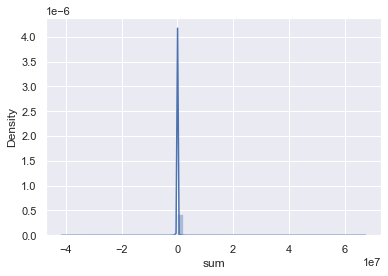

In [191]:
sns.distplot(df_joined['sum'])
plt.show()

#### Amount of transactions by code amd type descriptions

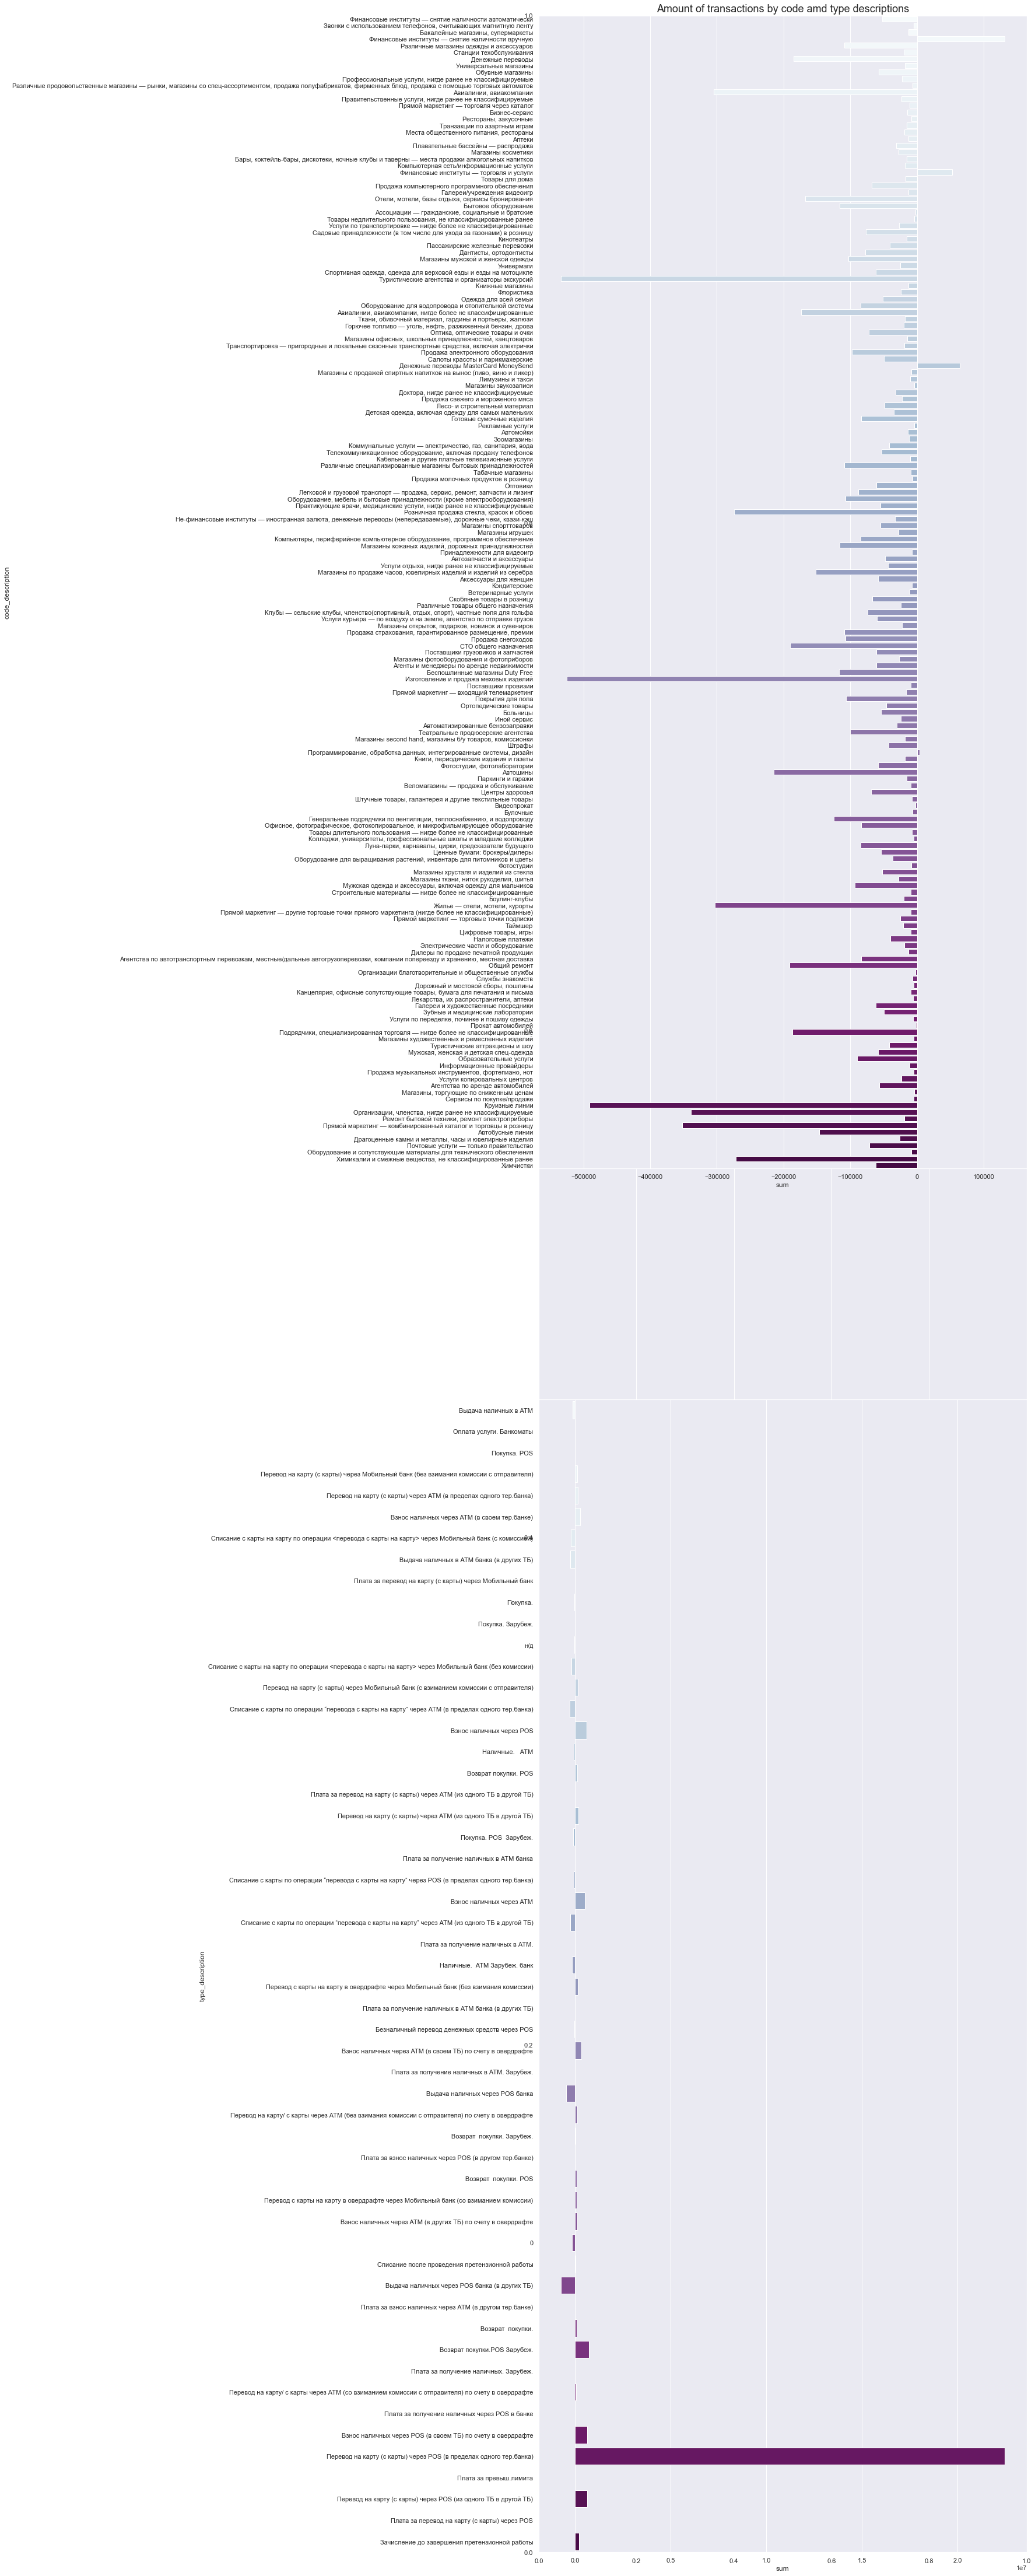

In [218]:
fig = plt.figure(figsize=(15, 80))
plt.title('Amount of transactions by code amd type descriptions', size=18)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sns.barplot(data=df_joined, y='code_description', x='sum', ax= ax1, palette='BuPu', ci= None)
sns.barplot(data=df_joined, y='type_description', x='sum', ax= ax2, palette='BuPu', ci= None)

plt.show()

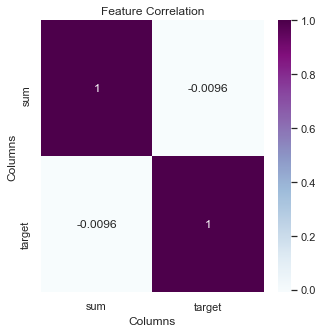

In [29]:
# correlation between gender and amounts of transactions
fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(df_joined.corr(), annot=True, ax=ax, cmap="BuPu").set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

Graph of Frequency of TOP 20 Type of transactions. As we can see from the graph, Покупка POS and выдача наличных в ATM are most popular ones.

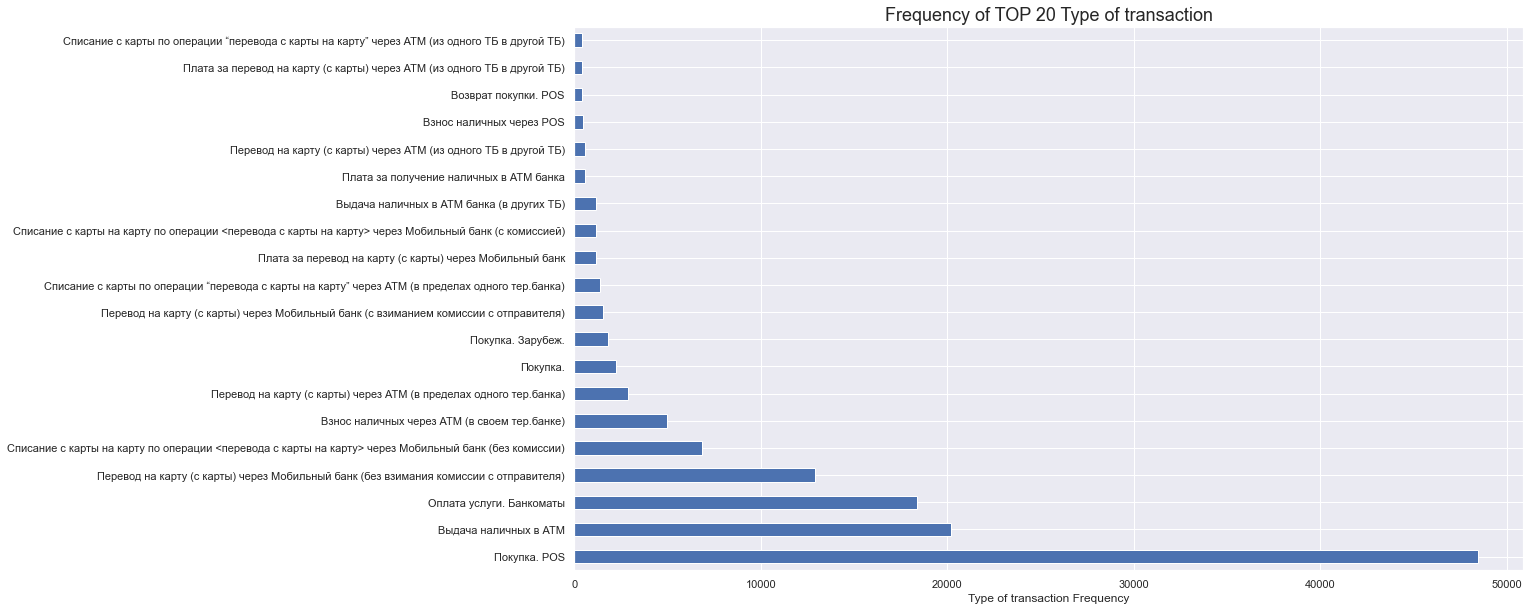

In [224]:
plt.figure(figsize=(17,10))
df.type_description.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Type of transaction Frequency')
plt.title("Frequency of TOP 20 Type of transaction",fontsize=18)
plt.show()

Graph of Frequency of TOP 20 Code of transactions. As we can see from the graph, Финансовые институты — снятие наличности aвтоматически and Финансовые институты — снятие наличности вручную are most popular ones.

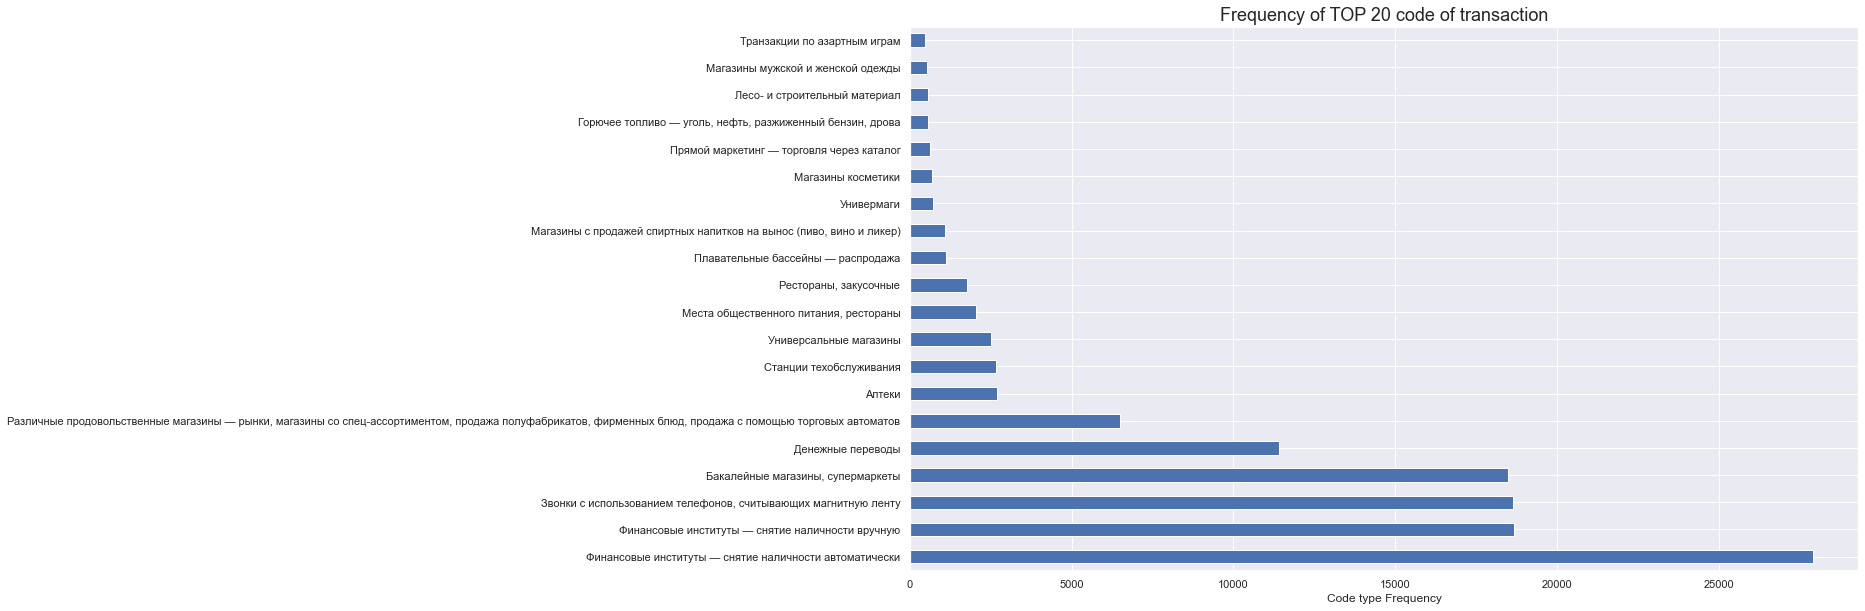

In [233]:
plt.figure(figsize=(17,10))
df.code_description.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Code type Frequency')
plt.title("Frequency of TOP 20 code of transaction",fontsize=18)
plt.show()

### Feature engineering

In this part we will make our data ready for model training

In [31]:
# Identifying feature columns
features = df_joined.columns[1:]
features

Index(['code', 'type', 'sum', 'code_description', 'type_description', 'target',
       'day', 'time'],
      dtype='object')

In [32]:
df_joined.drop('code_description', axis='columns', inplace=True)

In [33]:
df_joined.drop('type_description', axis='columns', inplace=True)

In [34]:
df_joined.drop('time', axis='columns', inplace=True)

In [35]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  91826 non-null  object 
 1   code       91826 non-null  object 
 2   type       91826 non-null  object 
 3   sum        91826 non-null  float64
 4   target     91826 non-null  float64
 5   day        91826 non-null  object 
dtypes: float64(2), object(4)
memory usage: 4.2+ MB


In [36]:
df_joined["code"]=df_joined["code"].astype(str).astype(float)

In [37]:
df_joined["type"]=df_joined["type"].astype(str).astype(float)

In [38]:
df_joined["day"]=df_joined["day"].astype(str).astype(float)

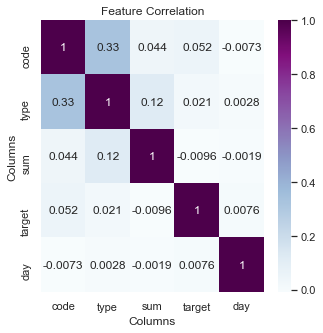

In [39]:
# correlation between gender and amounts of transactions
fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(df_joined.corr(), annot=True, ax=ax, cmap="BuPu").set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

In [40]:
X = df_joined.values
X = np.nan_to_num(X)

sc = StandardScaler()

cluster_data = sc.fit_transform(X)
print(cl('Cluster data samples : ', attrs = ['bold']), cluster_data[:5])

Cluster data samples :  [[ 1.57323554  0.6884737  -0.23501079 -0.87417515 -0.98268211  1.36698954]
 [-1.05552774  0.6884737  -0.23501079 -0.04532599 -0.98268211 -1.44433108]
 [ 1.18343625 -1.29943102 -0.66192027  0.02134232 -0.98268211 -0.70693551]
 [-0.71383204 -0.30796977 -0.62707051  0.02422527 -0.98268211  1.19032185]
 [ 1.16668999  0.68681296  1.96923609  0.03582159  1.01762308  1.38235195]]


### Unsupervised learning
### Modeling

In [41]:
clusters = 3
model = KMeans(init = 'k-means++', 
               n_clusters = clusters, 
               n_init = 12)
model.fit(X)

labels = model.labels_
print(cl(labels[:100], attrs = ['bold']))

[2 1 2 1 2 2 2 1 2 1 1 1 2 2 0 2 2 2 2 1 2 0 0 1 0 2 2 1 2 1 2 1 0 2 0 2 2
 2 2 1 1 2 2 0 1 2 2 2 2 0 1 2 0 0 2 2 1 2 0 1 2 2 0 2 1 1 0 0 0 1 2 2 0 0
 2 2 0 2 0 1 1 1 1 1 0 2 2 1 2 2 1 2 0 0 0 1 1 0 1 1]


In [42]:
df_joined['cluster_num'] = labels
df_joined.head()

,client_id,code,type,sum,target,day,cluster_num
0,96372458,6011.0,2010.0,-561478.94,0.0,421.0,2
1,21717441,6011.0,2010.0,-44918.32,0.0,55.0,1
2,85302434,4814.0,1030.0,-3368.87,0.0,151.0,2
3,31421357,5411.0,1110.0,-1572.14,0.0,398.0,1
4,84826852,6010.0,7070.0,5654.99,1.0,423.0,2


In [43]:
df_joined.groupby('cluster_num').mean()

,code,type,sum,target,day
cluster_num,,,,,
0,5580.395041,2415.258440,-11317.747498,0.460354,243.609050
1,5584.866667,2351.862005,-21590.721714,0.492184,244.615948
2,5618.647037,2816.964900,-16956.090426,0.515220,241.293051


Let’s look at the distribution of customers based on their type and transactions amount using a bubble plot and the color represents the cluster value.

/Users/tomiriszhaksylyk/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


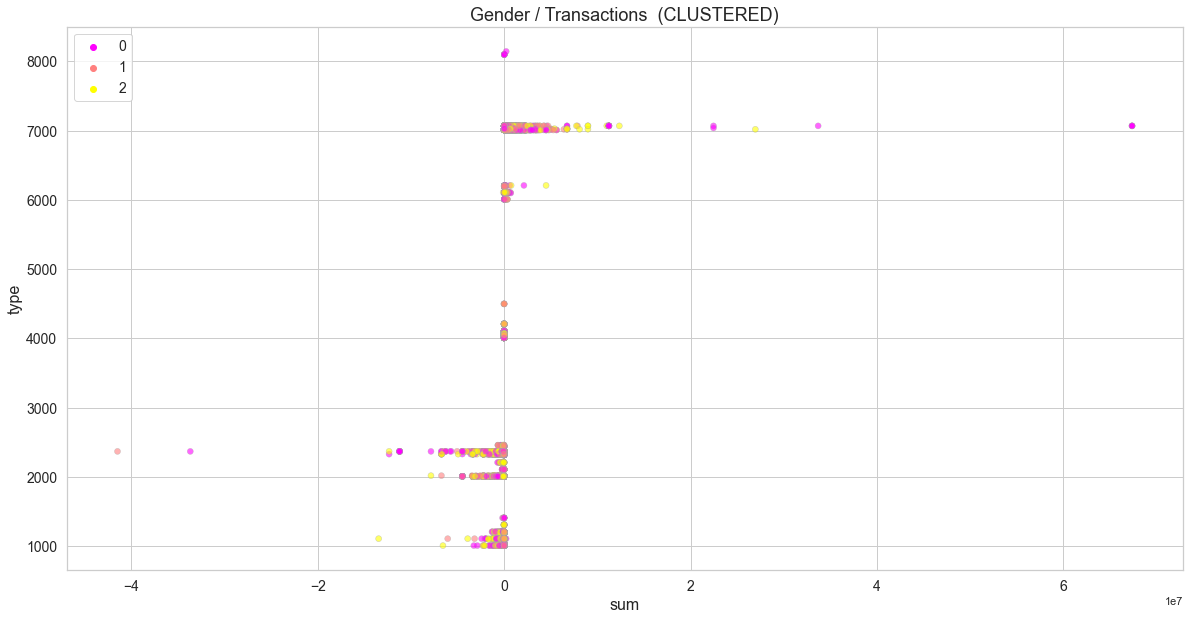

In [44]:
sb.scatterplot('sum', 'type', 
               data = df_joined, 
               hue = 'cluster_num', 
               palette = 'spring', 
               alpha = 0.6, 
               edgecolor = 'darkgrey')
plt.title('Gender / Transactions  (CLUSTERED)', 
          fontsize = 18)
plt.xlabel('sum', 
           fontsize = 16)
plt.ylabel('type', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 14)

plt.show()

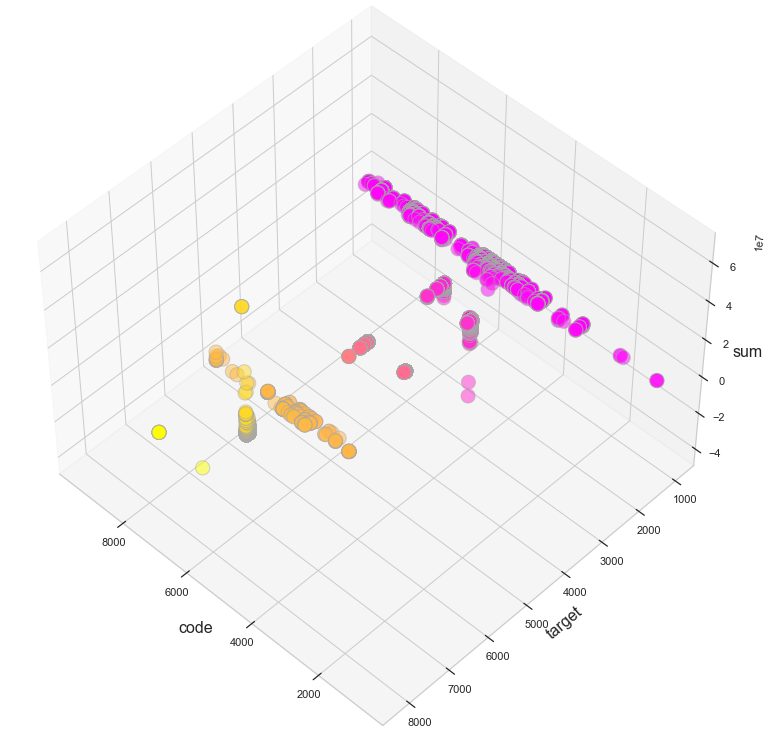

In [45]:
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, 
            rect = [0, 0, .95, 1], 
            elev = 48, 
            azim = 134)

plt.cla()
ax.scatter(df_joined['code'], df_joined['type'], df_joined['sum'], 
           c = df_joined['type'], 
           s = 200, 
           cmap = 'spring', 
           alpha = 0.5, 
           edgecolor = 'darkgrey')
ax.set_xlabel('code', 
              fontsize = 16)
ax.set_ylabel('target', 
              fontsize = 16)
ax.set_zlabel('sum', 
              fontsize = 16)

plt.show()

Our K-Means model has partitioned the customers into mutually exclusive groups, which are three clusters in our case.

The customers in each cluster are similar to each other demographically. Now we can create a profile for each group, considering the common characteristics of each cluster. 

In [46]:
import scipy.cluster.hierarchy as sch

In [47]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')